In [3]:
import glob
import os
import random
import spacy
import string
from sklearn.model_selection import train_test_split 
import pickle as pkl
import nltk
from nltk.util import ngrams
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab 
from torch.optim import lr_scheduler
import copy
import pandas as pd

# Read Train Data

In [4]:
file_list_pos = glob.glob(os.path.join(os.getcwd(), "aclImdb/train/pos/", "*.txt"))
file_list_neg = glob.glob(os.path.join(os.getcwd(), "aclImdb/train/neg/", "*.txt"))

train = []

for file_path in file_list_pos:
    with open(file_path) as f_input:
        train.append([f_input.read(),1])
train
for file_path in file_list_neg:
    with open(file_path) as f_input:
        train.append([f_input.read(),0])
        
# print (train[random.randint(0, len(train) - 1)])

# Read Test Data

In [5]:
file_list_pos = glob.glob(os.path.join(os.getcwd(), "aclImdb/test/pos/", "*.txt"))
file_list_neg = glob.glob(os.path.join(os.getcwd(), "aclImdb/test/neg/", "*.txt"))

test = []

for file_path in file_list_pos:
    with open(file_path) as f_input:
        test.append([f_input.read(),1])

for file_path in file_list_neg:
    with open(file_path) as f_input:
        test.append([f_input.read(),0])
        
# print (test[random.randint(0, len(test) - 1)])

# Split train data into train and val data

In [6]:
X_train = [i[0] for i in train]
y_train = [i[1] for i in train]

X_test = [i[0] for i in test]
y_test = [i[1] for i in test]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 5000, random_state = 42)

print(len(X_train),len(X_val),len(X_test))
print(len(y_train),len(y_val),len(y_test))

20000 5000 25000
20000 5000 25000


# Tokenizing

In [ ]:
#### Customize token pipeline for html

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token

# we're using a class because the component needs to be initialised with
# the shared vocab via the nlp object
class BadHTMLMerger(object):
    def __init__(self, nlp):
        # register a new token extension to flag bad HTML
        Token.set_extension('bad_html', default=False)
        self.matcher = Matcher(nlp.vocab)
        self.matcher.add('BAD_HTML', None,
            [{'ORTH': '<'}, {'LOWER': 'br'}, {'ORTH': '>'}],
            [{'ORTH': '<'}, {'LOWER': 'br/'}, {'ORTH': '>'}])

    def __call__(self, doc):
        # this method is invoked when the component is called on a Doc
        matches = self.matcher(doc)
        spans = []  # collect the matched spans here
        for match_id, start, end in matches:
            spans.append(doc[start:end])
        for span in spans:
            span.merge()   # merge
            for token in span:
                token._.bad_html = True  # mark token as bad HTML
        return doc

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
html_merger = BadHTMLMerger(tokenizer)
tokenizer.add_pipe(html_merger, last=True) 

punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations) and (not token.is_stop)]


def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [5]:
# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(X_val)
# pkl.dump(val_data_tokens, open("val_data_tokens1.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(X_test)
# pkl.dump(test_data_tokens, open("test_data_tokens1.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(X_train)
# pkl.dump(train_data_tokens, open("train_data_tokens1.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens1.p", "wb"))

In [7]:
# reload pickle
train_data_tokens = pkl.load(open("train_data_tokens1.p", "rb")) 
### each sentence is lowercase and remove punctuation and there is a big list of smaller list
### each small list is the split words of the ogirinal text sentect
all_train_tokens = pkl.load(open("all_train_tokens1.p", "rb"))  ### all unigram vocubular

val_data_tokens = pkl.load(open("val_data_tokens1.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens1.p", "rb"))

# N-grams

In [8]:
max_vocab_size = 10000
# save index 1 for unk and 0 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,n):
    ## This function is to transfer unigram to n gram and return mapping criteria from token to index 
    # all_tokens = unigram token vocabulary 
    # n is n_grams
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    all_tokens = [' '.join(i) for i in ngrams(all_train_tokens,n)]  ## ngrams comes from NLTK
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token   # token2id is the most important one

# convert token to id in the dataset
def token2index_dataset(tokens_data,all_train_tokens,n):
    token2id, id2token = build_vocab(all_train_tokens,n)
    
    indices_data = []
    for tokens in tokens_data:
        tokens = [' '.join(i) for i in ngrams(tokens,n)]
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data,id2token

train_data_indices,id2token = token2index_dataset(train_data_tokens,all_train_tokens,1)
val_data_indices,_ = token2index_dataset(val_data_tokens,all_train_tokens,1)
test_data_indices, _ = token2index_dataset(test_data_tokens,all_train_tokens,1)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


# Pytorch DataLoader

In [9]:
MAX_SENTENCE_LENGTH = 200

class ImdbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:   ### batch = sample
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])),          ### 0代表左边没有pad,右边的值代表右边pad的个数
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
#As another example, several loss functions like CrossEntropyLoss require that the target should be torch LongTensor. So before doing operations, make sure that your input Tensor types match the function definitions.


# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = ImdbDataset(train_data_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,   # collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
                                           shuffle=True)
'''
- With data loader you can easily do :
- mini batches
- shuffling
- special sampling
- asynchronous loading with multiple workers
'''


val_dataset = ImdbDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = ImdbDataset(test_data_indices, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

# Define bag-of-n-words model 

In [10]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. |V|
        @param emb_dim: size of the word embedding  d
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)   # nn.Linear(input, output)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


# Model and Hyper-parameter Tuning

In [11]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)  ### 一个batch有32个sample 所以labels.size(0) =32
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

'''
ngrams         predefined 1,2,3,4
max_vocab_size predefined 10000,20000

emb_dim        grid       100,200,300,400,500
optimizer      grid       'Adam','SGD'
lr_rate        grid       0.0005,0.001
adjusted       grid       'yes','no','linear'
'''

def tuning(emb_dim, optimizer, learning_rate,adjusted):
    BATCH_SIZE = 32
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,   # collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 30 # number epoch to train
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()   
    opt = 'torch.optim.'+ optimizer + '(model.parameters(), lr=learning_rate)'
    print(opt)
    optimizer = eval(opt)

    if adjusted == 'yes':
        num_epochs = 50
        lambda1 = lambda epoch: 0.95 ** num_epochs
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1) 
    
    train_loss_list =[]
    val_acc_list = []
    model_list = []
    
    for epoch in range(num_epochs):
        if adjusted == 'yes':
            scheduler.step()
            
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()     
            optimizer.step()
 
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                
                train_loss_list.append(loss)
                val_acc_list.append(val_acc)
                model_list.append(model)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), float(loss),val_acc))
    
    idx = val_acc_list.index(max(val_acc_list))
    print("The best model is with Loss: {}, Validation Acc: {}".format(train_loss_list[idx],val_acc_list[idx]))
    print(test_model(test_loader,model_list[idx]))
    
    return train_loss_list,val_acc_list,model_list[idx]

# ngram = 1, max_vocab_size = 10000

### Test Exponential/Fixed decaying learning rate for Adam/SGD

In [13]:
grid = {'emb_dim':[100,200,300],'optimizer':['Adam','SGD'], 'learning_rate': [0.0005,0.001],'adjusted':["yes","no"]}
num_comb = len(ParameterGrid(grid))
count = 0

Models = []
for j in range(len(ParameterGrid(grid))):
    count += 1
    print("Now it is {} out of {} combinations".format(count, num_comb))
    optimizer,learning_rate, emb_dim,adjusted = ParameterGrid(grid)[j].values()
    myCsvRow = "optimizer = {}, learning_rate = {}, emb_dim = {}, adjusted = {}".format(optimizer, learning_rate, emb_dim,adjusted)
    print(myCsvRow)
    Models.append(tuning(emb_dim, optimizer, learning_rate,adjusted))
    print()

Now it is 1 out of 24 combinations
optimizer = Adam, learning_rate = 0.0005, emb_dim = 100, adjusted = yes
torch.optim.Adam(model.parameters(), lr=learning_rate)
Epoch: [1/50], Step: [625/625], Loss: 2.462599277496338, Validation Acc: 50.04
Epoch: [2/50], Step: [625/625], Loss: 1.939391851425171, Validation Acc: 51.02
Epoch: [3/50], Step: [625/625], Loss: 1.5248795747756958, Validation Acc: 51.7
Epoch: [4/50], Step: [625/625], Loss: 1.1673545837402344, Validation Acc: 53.02
Epoch: [5/50], Step: [625/625], Loss: 1.0207655429840088, Validation Acc: 55.88
Epoch: [6/50], Step: [625/625], Loss: 0.837187647819519, Validation Acc: 57.32
Epoch: [7/50], Step: [625/625], Loss: 0.7951300144195557, Validation Acc: 59.06
Epoch: [8/50], Step: [625/625], Loss: 0.744631290435791, Validation Acc: 61.0
Epoch: [9/50], Step: [625/625], Loss: 0.7343262434005737, Validation Acc: 62.64
Epoch: [10/50], Step: [625/625], Loss: 0.6968206167221069, Validation Acc: 64.4
Epoch: [11/50], Step: [625/625], Loss: 0.700

Epoch: [48/50], Step: [625/625], Loss: 1.9284299612045288, Validation Acc: 48.82
Epoch: [49/50], Step: [625/625], Loss: 1.894580602645874, Validation Acc: 48.94
Epoch: [50/50], Step: [625/625], Loss: 1.9067659378051758, Validation Acc: 49.18
The best model is with Loss: 1.9067659378051758, Validation Acc: 49.18
48.26

Now it is 3 out of 24 combinations
optimizer = Adam, learning_rate = 0.001, emb_dim = 100, adjusted = yes
torch.optim.Adam(model.parameters(), lr=learning_rate)
Epoch: [1/50], Step: [625/625], Loss: 1.9003076553344727, Validation Acc: 50.56
Epoch: [2/50], Step: [625/625], Loss: 1.1350979804992676, Validation Acc: 51.8
Epoch: [3/50], Step: [625/625], Loss: 0.9146232604980469, Validation Acc: 57.98
Epoch: [4/50], Step: [625/625], Loss: 0.7985407114028931, Validation Acc: 62.52
Epoch: [5/50], Step: [625/625], Loss: 0.7344676852226257, Validation Acc: 66.48
Epoch: [6/50], Step: [625/625], Loss: 0.6879033446311951, Validation Acc: 68.8
Epoch: [7/50], Step: [625/625], Loss: 0.6

Epoch: [44/50], Step: [625/625], Loss: 1.376935601234436, Validation Acc: 51.5
Epoch: [45/50], Step: [625/625], Loss: 1.3958675861358643, Validation Acc: 51.5
Epoch: [46/50], Step: [625/625], Loss: 1.3976880311965942, Validation Acc: 51.54
Epoch: [47/50], Step: [625/625], Loss: 1.3463413715362549, Validation Acc: 51.48
Epoch: [48/50], Step: [625/625], Loss: 1.3332345485687256, Validation Acc: 51.62
Epoch: [49/50], Step: [625/625], Loss: 1.3373583555221558, Validation Acc: 51.7
Epoch: [50/50], Step: [625/625], Loss: 1.2546113729476929, Validation Acc: 51.8
The best model is with Loss: 1.2546113729476929, Validation Acc: 51.8
51.772

Now it is 5 out of 24 combinations
optimizer = Adam, learning_rate = 0.0005, emb_dim = 200, adjusted = yes
torch.optim.Adam(model.parameters(), lr=learning_rate)
Epoch: [1/50], Step: [625/625], Loss: 2.1548821926116943, Validation Acc: 49.92
Epoch: [2/50], Step: [625/625], Loss: 1.5271018743515015, Validation Acc: 51.18
Epoch: [3/50], Step: [625/625], Loss: 

Epoch: [40/50], Step: [625/625], Loss: 1.7511786222457886, Validation Acc: 47.96
Epoch: [41/50], Step: [625/625], Loss: 1.7116429805755615, Validation Acc: 48.1
Epoch: [42/50], Step: [625/625], Loss: 1.6234685182571411, Validation Acc: 48.24
Epoch: [43/50], Step: [625/625], Loss: 1.6664047241210938, Validation Acc: 48.46
Epoch: [44/50], Step: [625/625], Loss: 1.635946273803711, Validation Acc: 48.5
Epoch: [45/50], Step: [625/625], Loss: 1.5726077556610107, Validation Acc: 48.44
Epoch: [46/50], Step: [625/625], Loss: 1.5876600742340088, Validation Acc: 48.64
Epoch: [47/50], Step: [625/625], Loss: 1.6581348180770874, Validation Acc: 48.8
Epoch: [48/50], Step: [625/625], Loss: 1.6330070495605469, Validation Acc: 48.94
Epoch: [49/50], Step: [625/625], Loss: 1.5471947193145752, Validation Acc: 48.98
Epoch: [50/50], Step: [625/625], Loss: 1.5937719345092773, Validation Acc: 49.1
The best model is with Loss: 1.5937719345092773, Validation Acc: 49.1
50.176

Now it is 7 out of 24 combinations
o

Epoch: [36/50], Step: [625/625], Loss: 1.187531590461731, Validation Acc: 54.72
Epoch: [37/50], Step: [625/625], Loss: 1.2532886266708374, Validation Acc: 54.9
Epoch: [38/50], Step: [625/625], Loss: 1.2882837057113647, Validation Acc: 55.02
Epoch: [39/50], Step: [625/625], Loss: 1.2634401321411133, Validation Acc: 55.28
Epoch: [40/50], Step: [625/625], Loss: 1.1814815998077393, Validation Acc: 55.3
Epoch: [41/50], Step: [625/625], Loss: 1.228057622909546, Validation Acc: 55.38
Epoch: [42/50], Step: [625/625], Loss: 1.1450650691986084, Validation Acc: 55.42
Epoch: [43/50], Step: [625/625], Loss: 1.2448629140853882, Validation Acc: 55.44
Epoch: [44/50], Step: [625/625], Loss: 1.1528209447860718, Validation Acc: 55.58
Epoch: [45/50], Step: [625/625], Loss: 1.1126819849014282, Validation Acc: 55.88
Epoch: [46/50], Step: [625/625], Loss: 1.2114530801773071, Validation Acc: 55.96
Epoch: [47/50], Step: [625/625], Loss: 1.1820783615112305, Validation Acc: 55.88
Epoch: [48/50], Step: [625/625],

Epoch: [32/50], Step: [625/625], Loss: 1.781828761100769, Validation Acc: 52.06
Epoch: [33/50], Step: [625/625], Loss: 1.693253755569458, Validation Acc: 52.08
Epoch: [34/50], Step: [625/625], Loss: 1.7867536544799805, Validation Acc: 52.22
Epoch: [35/50], Step: [625/625], Loss: 1.6618125438690186, Validation Acc: 52.2
Epoch: [36/50], Step: [625/625], Loss: 1.657773733139038, Validation Acc: 52.3
Epoch: [37/50], Step: [625/625], Loss: 1.5567692518234253, Validation Acc: 52.44
Epoch: [38/50], Step: [625/625], Loss: 1.765939474105835, Validation Acc: 52.52
Epoch: [39/50], Step: [625/625], Loss: 1.6064298152923584, Validation Acc: 52.56
Epoch: [40/50], Step: [625/625], Loss: 1.5733246803283691, Validation Acc: 52.58
Epoch: [41/50], Step: [625/625], Loss: 1.5530532598495483, Validation Acc: 52.66
Epoch: [42/50], Step: [625/625], Loss: 1.5444092750549316, Validation Acc: 52.78
Epoch: [43/50], Step: [625/625], Loss: 1.5426005125045776, Validation Acc: 52.76
Epoch: [44/50], Step: [625/625], L

Epoch: [28/50], Step: [625/625], Loss: 1.264072060585022, Validation Acc: 56.16
Epoch: [29/50], Step: [625/625], Loss: 1.3451273441314697, Validation Acc: 56.28
Epoch: [30/50], Step: [625/625], Loss: 1.1862646341323853, Validation Acc: 56.48
Epoch: [31/50], Step: [625/625], Loss: 1.214674472808838, Validation Acc: 56.62
Epoch: [32/50], Step: [625/625], Loss: 1.1390411853790283, Validation Acc: 56.6
Epoch: [33/50], Step: [625/625], Loss: 1.210084319114685, Validation Acc: 57.0
Epoch: [34/50], Step: [625/625], Loss: 1.239384412765503, Validation Acc: 57.3
Epoch: [35/50], Step: [625/625], Loss: 1.2451778650283813, Validation Acc: 57.36
Epoch: [36/50], Step: [625/625], Loss: 1.2320070266723633, Validation Acc: 57.56
Epoch: [37/50], Step: [625/625], Loss: 1.1767324209213257, Validation Acc: 57.78
Epoch: [38/50], Step: [625/625], Loss: 1.1064565181732178, Validation Acc: 57.94
Epoch: [39/50], Step: [625/625], Loss: 1.1781216859817505, Validation Acc: 58.02
Epoch: [40/50], Step: [625/625], Lo

Epoch: [11/30], Step: [625/625], Loss: 0.061818525195121765, Validation Acc: 87.8
Epoch: [12/30], Step: [625/625], Loss: 0.11467130482196808, Validation Acc: 87.5
Epoch: [13/30], Step: [625/625], Loss: 0.060528554022312164, Validation Acc: 87.42
Epoch: [14/30], Step: [625/625], Loss: 0.04154852777719498, Validation Acc: 87.22
Epoch: [15/30], Step: [625/625], Loss: 0.04065079987049103, Validation Acc: 87.22
Epoch: [16/30], Step: [625/625], Loss: 0.015426114201545715, Validation Acc: 87.12
Epoch: [17/30], Step: [625/625], Loss: 0.037757501006126404, Validation Acc: 86.84
Epoch: [18/30], Step: [625/625], Loss: 0.040464356541633606, Validation Acc: 86.76
Epoch: [19/30], Step: [625/625], Loss: 0.06921698153018951, Validation Acc: 86.52
Epoch: [20/30], Step: [625/625], Loss: 0.021930143237113953, Validation Acc: 86.42
Epoch: [21/30], Step: [625/625], Loss: 0.014832302927970886, Validation Acc: 86.34
Epoch: [22/30], Step: [625/625], Loss: 0.022302046418190002, Validation Acc: 86.3
Epoch: [23/

Epoch: [14/30], Step: [625/625], Loss: 0.8507563471794128, Validation Acc: 60.92
Epoch: [15/30], Step: [625/625], Loss: 0.9217263460159302, Validation Acc: 61.18
Epoch: [16/30], Step: [625/625], Loss: 0.8752058744430542, Validation Acc: 61.44
Epoch: [17/30], Step: [625/625], Loss: 0.8336200714111328, Validation Acc: 61.64
Epoch: [18/30], Step: [625/625], Loss: 0.8357629776000977, Validation Acc: 61.8
Epoch: [19/30], Step: [625/625], Loss: 0.8350126147270203, Validation Acc: 62.28
Epoch: [20/30], Step: [625/625], Loss: 0.8248608112335205, Validation Acc: 62.44
Epoch: [21/30], Step: [625/625], Loss: 0.7880951166152954, Validation Acc: 62.82
Epoch: [22/30], Step: [625/625], Loss: 0.8002719879150391, Validation Acc: 62.88
Epoch: [23/30], Step: [625/625], Loss: 0.8039332628250122, Validation Acc: 63.16
Epoch: [24/30], Step: [625/625], Loss: 0.8085358142852783, Validation Acc: 63.32
Epoch: [25/30], Step: [625/625], Loss: 0.7665844559669495, Validation Acc: 63.78
Epoch: [26/30], Step: [625/62

Epoch: [17/30], Step: [625/625], Loss: 0.019216082990169525, Validation Acc: 87.1
Epoch: [18/30], Step: [625/625], Loss: 0.049684301018714905, Validation Acc: 87.14
Epoch: [19/30], Step: [625/625], Loss: 0.024125084280967712, Validation Acc: 87.06
Epoch: [20/30], Step: [625/625], Loss: 0.0766516774892807, Validation Acc: 87.0
Epoch: [21/30], Step: [625/625], Loss: 0.031427666544914246, Validation Acc: 86.92
Epoch: [22/30], Step: [625/625], Loss: 0.015118137001991272, Validation Acc: 86.86
Epoch: [23/30], Step: [625/625], Loss: 0.07028570771217346, Validation Acc: 86.8
Epoch: [24/30], Step: [625/625], Loss: 0.05385693907737732, Validation Acc: 86.66
Epoch: [25/30], Step: [625/625], Loss: 0.025401577353477478, Validation Acc: 86.44
Epoch: [26/30], Step: [625/625], Loss: 0.023761823773384094, Validation Acc: 86.42
Epoch: [27/30], Step: [625/625], Loss: 0.03844354301691055, Validation Acc: 86.22
Epoch: [28/30], Step: [625/625], Loss: 0.012848809361457825, Validation Acc: 86.24
Epoch: [29/3

Epoch: [20/30], Step: [625/625], Loss: 0.7293038368225098, Validation Acc: 66.44
Epoch: [21/30], Step: [625/625], Loss: 0.703319787979126, Validation Acc: 66.68
Epoch: [22/30], Step: [625/625], Loss: 0.6940010190010071, Validation Acc: 67.0
Epoch: [23/30], Step: [625/625], Loss: 0.7043876051902771, Validation Acc: 67.06
Epoch: [24/30], Step: [625/625], Loss: 0.7012636661529541, Validation Acc: 67.12
Epoch: [25/30], Step: [625/625], Loss: 0.7191475629806519, Validation Acc: 67.36
Epoch: [26/30], Step: [625/625], Loss: 0.723880410194397, Validation Acc: 67.46
Epoch: [27/30], Step: [625/625], Loss: 0.7198768258094788, Validation Acc: 67.86
Epoch: [28/30], Step: [625/625], Loss: 0.6707451343536377, Validation Acc: 67.9
Epoch: [29/30], Step: [625/625], Loss: 0.7323625087738037, Validation Acc: 68.14
Epoch: [30/30], Step: [625/625], Loss: 0.6825371980667114, Validation Acc: 68.22
The best model is with Loss: 0.6825371980667114, Validation Acc: 68.22
67.808



### Test Linearly decaying learning rate under Adam

In [14]:
def tuning2(emb_dim, learning_rate, adjusted):
    BATCH_SIZE = 32
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,   # collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 30 # number epoch to train
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()   
    
    c = copy.copy(learning_rate)
    
    train_loss_list =[]
    val_acc_list = []
    model_list = []
    
    for epoch in range(num_epochs):          
        if adjusted == 'linear':
            learning_rate = learning_rate - c/(num_epochs + 10)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()     
            optimizer.step()
 
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                
                train_loss_list.append(loss)
                val_acc_list.append(val_acc)
                model_list.append(model)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), float(loss),val_acc))
    
    idx = val_acc_list.index(max(val_acc_list))
    print("The best model is with Loss: {}, Validation Acc: {}".format(train_loss_list[idx],val_acc_list[idx]))
    print(test_model(test_loader,model_list[idx]))
    
    return train_loss_list,val_acc_list,model_list[idx]

grid = {'emb_dim':[100,200,300], 'learning_rate': [0.0005,0.001],'adjusted':["linear"]}
num_comb = len(ParameterGrid(grid))
count = 0

for j in range(len(ParameterGrid(grid))):
    count += 1
    print("Now it is {} out of {} combinations".format(count, num_comb))
    learning_rate, emb_dim,adjusted = ParameterGrid(grid)[j].values()
    myCsvRow = "learning_rate = {}, emb_dim = {}, adjusted = {}".format(learning_rate, emb_dim,adjusted)
    print(myCsvRow)
    Models.append(tuning(emb_dim, optimizer, learning_rate,adjusted))
    print()

Now it is 1 out of 6 combinations
learning_rate = 0.0005, emb_dim = 100, adjusted = linear
torch.optim.SGD(model.parameters(), lr=learning_rate)
Epoch: [1/30], Step: [625/625], Loss: 2.7277629375457764, Validation Acc: 49.5
Epoch: [2/30], Step: [625/625], Loss: 2.451334238052368, Validation Acc: 52.7
Epoch: [3/30], Step: [625/625], Loss: 2.188551664352417, Validation Acc: 53.08
Epoch: [4/30], Step: [625/625], Loss: 1.9592223167419434, Validation Acc: 53.16
Epoch: [5/30], Step: [625/625], Loss: 1.7653148174285889, Validation Acc: 53.58
Epoch: [6/30], Step: [625/625], Loss: 1.654492735862732, Validation Acc: 53.56
Epoch: [7/30], Step: [625/625], Loss: 1.4739508628845215, Validation Acc: 53.76
Epoch: [8/30], Step: [625/625], Loss: 1.2958706617355347, Validation Acc: 54.02
Epoch: [9/30], Step: [625/625], Loss: 1.2944691181182861, Validation Acc: 54.64
Epoch: [10/30], Step: [625/625], Loss: 1.2702302932739258, Validation Acc: 54.92
Epoch: [11/30], Step: [625/625], Loss: 1.2341912984848022, 

Epoch: [3/30], Step: [625/625], Loss: 1.2395724058151245, Validation Acc: 56.16
Epoch: [4/30], Step: [625/625], Loss: 1.1952016353607178, Validation Acc: 57.16
Epoch: [5/30], Step: [625/625], Loss: 0.9945226907730103, Validation Acc: 57.92
Epoch: [6/30], Step: [625/625], Loss: 0.9572011232376099, Validation Acc: 58.64
Epoch: [7/30], Step: [625/625], Loss: 0.9177641868591309, Validation Acc: 59.68
Epoch: [8/30], Step: [625/625], Loss: 0.901366651058197, Validation Acc: 60.04
Epoch: [9/30], Step: [625/625], Loss: 0.8379554748535156, Validation Acc: 60.52
Epoch: [10/30], Step: [625/625], Loss: 0.8368090391159058, Validation Acc: 61.08
Epoch: [11/30], Step: [625/625], Loss: 0.8532904982566833, Validation Acc: 61.42
Epoch: [12/30], Step: [625/625], Loss: 0.778679609298706, Validation Acc: 61.98
Epoch: [13/30], Step: [625/625], Loss: 0.8324873447418213, Validation Acc: 62.62
Epoch: [14/30], Step: [625/625], Loss: 0.7337512969970703, Validation Acc: 63.26
Epoch: [15/30], Step: [625/625], Loss

## Test Linearly decaying learning rate under SGD

In [17]:
def tuning3(emb_dim, learning_rate, adjusted):
    BATCH_SIZE = 32
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,   # collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 30 # number epoch to train
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()   
    
    c = copy.copy(learning_rate)
    
    train_loss_list =[]
    val_acc_list = []
    model_list = []
    
    for epoch in range(num_epochs):          
        if adjusted == 'linear':
            learning_rate = learning_rate - c/(num_epochs + 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()     
            optimizer.step()
 
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                
                train_loss_list.append(loss)
                val_acc_list.append(val_acc)
                model_list.append(model)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), float(loss),val_acc))
    
    idx = val_acc_list.index(max(val_acc_list))
    print("The best model is with Loss: {}, Validation Acc: {}".format(train_loss_list[idx],val_acc_list[idx]))
    print(test_model(test_loader,model_list[idx]))
    
    return train_loss_list,val_acc_list,model_list[idx]

grid = {'emb_dim':[100,200,300], 'learning_rate': [0.0005,0.001],'adjusted':["linear"]}
num_comb = len(ParameterGrid(grid))
count = 0

for j in range(len(ParameterGrid(grid))):
    count += 1
    print("Now it is {} out of {} combinations".format(count, num_comb))
    learning_rate, emb_dim,adjusted = ParameterGrid(grid)[j].values()
    myCsvRow = "learning_rate = {}, emb_dim = {}, adjusted = {}".format(learning_rate, emb_dim,adjusted)
    print(myCsvRow)
    Models.append(tuning(emb_dim, optimizer, learning_rate,adjusted))
    print()

Now it is 1 out of 6 combinations
learning_rate = 0.0005, emb_dim = 100, adjusted = linear
torch.optim.SGD(model.parameters(), lr=learning_rate)
Epoch: [1/30], Step: [625/625], Loss: 2.7438912391662598, Validation Acc: 48.66
Epoch: [2/30], Step: [625/625], Loss: 2.522106170654297, Validation Acc: 49.68
Epoch: [3/30], Step: [625/625], Loss: 2.1780893802642822, Validation Acc: 50.12
Epoch: [4/30], Step: [625/625], Loss: 1.9573442935943604, Validation Acc: 50.38
Epoch: [5/30], Step: [625/625], Loss: 1.8180660009384155, Validation Acc: 50.58
Epoch: [6/30], Step: [625/625], Loss: 1.6223148107528687, Validation Acc: 50.68
Epoch: [7/30], Step: [625/625], Loss: 1.5913350582122803, Validation Acc: 51.18
Epoch: [8/30], Step: [625/625], Loss: 1.369180679321289, Validation Acc: 51.94
Epoch: [9/30], Step: [625/625], Loss: 1.322234869003296, Validation Acc: 52.7
Epoch: [10/30], Step: [625/625], Loss: 1.2429755926132202, Validation Acc: 53.24
Epoch: [11/30], Step: [625/625], Loss: 1.1305723190307617,

Epoch: [3/30], Step: [625/625], Loss: 1.1935160160064697, Validation Acc: 55.18
Epoch: [4/30], Step: [625/625], Loss: 1.0286810398101807, Validation Acc: 55.86
Epoch: [5/30], Step: [625/625], Loss: 0.995202362537384, Validation Acc: 56.92
Epoch: [6/30], Step: [625/625], Loss: 1.016330361366272, Validation Acc: 58.0
Epoch: [7/30], Step: [625/625], Loss: 0.9120796322822571, Validation Acc: 58.66
Epoch: [8/30], Step: [625/625], Loss: 0.8540576696395874, Validation Acc: 59.7
Epoch: [9/30], Step: [625/625], Loss: 0.7728350162506104, Validation Acc: 60.38
Epoch: [10/30], Step: [625/625], Loss: 0.7828467488288879, Validation Acc: 61.14
Epoch: [11/30], Step: [625/625], Loss: 0.8022114038467407, Validation Acc: 61.74
Epoch: [12/30], Step: [625/625], Loss: 0.8406280279159546, Validation Acc: 62.14
Epoch: [13/30], Step: [625/625], Loss: 0.7680889368057251, Validation Acc: 62.4
Epoch: [14/30], Step: [625/625], Loss: 0.749789297580719, Validation Acc: 62.8
Epoch: [15/30], Step: [625/625], Loss: 0.7

In [20]:
best_acc = max([max(model[1]) for model in Models])
best_model_idx = [max(model[1]) for model in Models].index(best_acc)
print("Highest Val Acc is {}, test Acc is 86.692, and index is {}".format(best_acc,best_model_idx))
val_list = Models[best_model_idx][1]
loss_list = [float(i) for i in Models[best_model_idx][0]]

Highest Val Acc is 88.42, test Acc is 86.692, and index is 10


# Plot

(80, 91)

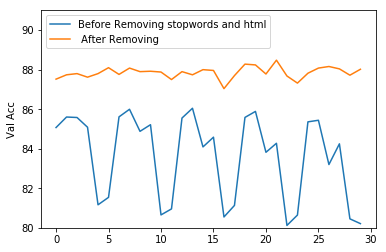

In [87]:
pylab.plot(with_, label = 'Before Removing stopwords and html')
pylab.plot(without_Val, label = ' After Removing')
pylab.ylabel('Val Acc')
pylab.legend(loc='upper left')
pylab.ylim(80, 91)

83.61866666666667
82.10519999999998
76.90586666666667
83.4728
83.29600000000002
78.28066666666668


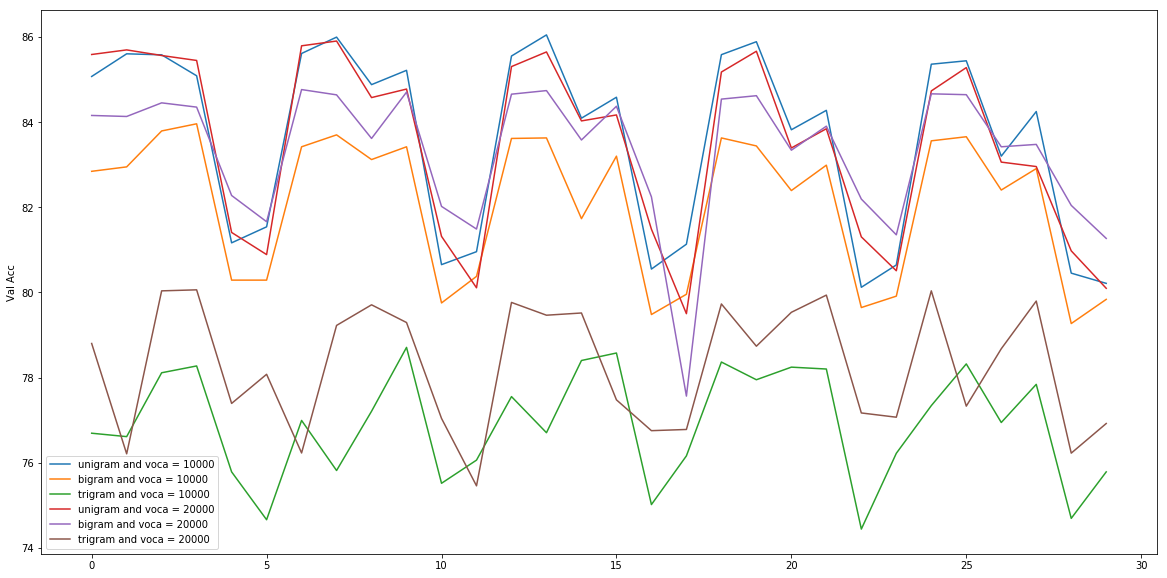

In [141]:
# Since I forget to save value then I have to copy each from output from above to below
n1_10000 = [85.072,85.604,85.58,85.088,81.164,81.54,85.612,85.996,84.88,85.216,80.652,80.956,85.552,86.048,84.092,84.584,80.548,81.132,85.584,85.888,83.82,84.276,80.12,80.644,85.36,85.44,83.2,84.248,80.452,80.212]
n2_10000 = [82.844,82.948,83.792,83.96,80.288,80.288,83.42,83.7,83.12,83.42,79.752,80.376,83.616,83.628,81.732,83.2,79.48,79.956,83.628,83.44,82.392,82.988,79.644,79.912,83.56,83.656,82.404,82.908,79.268,79.836]
n3_10000 = [76.692,76.612,78.112,78.272,75.784,74.66, 76.992,75.816,77.208,78.708,75.516,76.06,77.552,76.704,78.4,78.576,75.016,76.16,78.364,77.948,78.244,78.2,74.44,76.22,77.34,78.32,76.944,77.84,74.692,75.784]

n3_20000 = [78.8,76.208,80.036,80.06,77.392,78.076,76.228,79.224,79.708,79.292,77.04,75.456,79.764,79.464,79.516,77.476,76.752,76.78,79.728,78.736,79.532,79.936,77.168,77.068,80.036,77.328,78.676,79.796,76.224,76.92]
n2_20000 = [84.156,84.132,84.452,84.352,82.276,81.66,84.764,84.64,83.616,84.704,82.02,81.488,84.656,84.74,83.58,84.372,82.244,77.564,84.54,84.62,83.34,83.904,82.192,81.352,84.664,84.644,83.42,83.476,82.044,81.268]
n1_20000 = [85.588,85.696,85.564,85.448,81.408,80.888,85.792,85.904,84.576,84.776,81.316,80.108,85.304,85.648,84.028,84.168,81.484,79.5,85.176,85.664,83.392,83.844,81.304,80.508,84.732,85.28,83.06,82.956,80.976,80.096]

print(np.mean(n1_10000))
print(np.mean(n2_10000))
print(np.mean(n3_10000))
print(np.mean(n1_20000))
print(np.mean(n2_20000))
print(np.mean(n3_20000))

plt.figure(figsize=(20,10))

plt.plot(n1_10000, label = 'unigram and voca = 10000')
plt.plot(n2_10000, label = 'bigram and voca = 10000')
plt.plot(n3_10000, label = 'trigram and voca = 10000')
plt.plot(n1_20000, label = 'unigram and voca = 20000')
plt.plot(n2_20000, label = 'bigram and voca = 20000')
plt.plot(n3_20000, label = 'trigram and voca = 20000')
plt.ylabel('Val Acc')
plt.legend()

# All Combination hyper-parameter Validation Accuracy

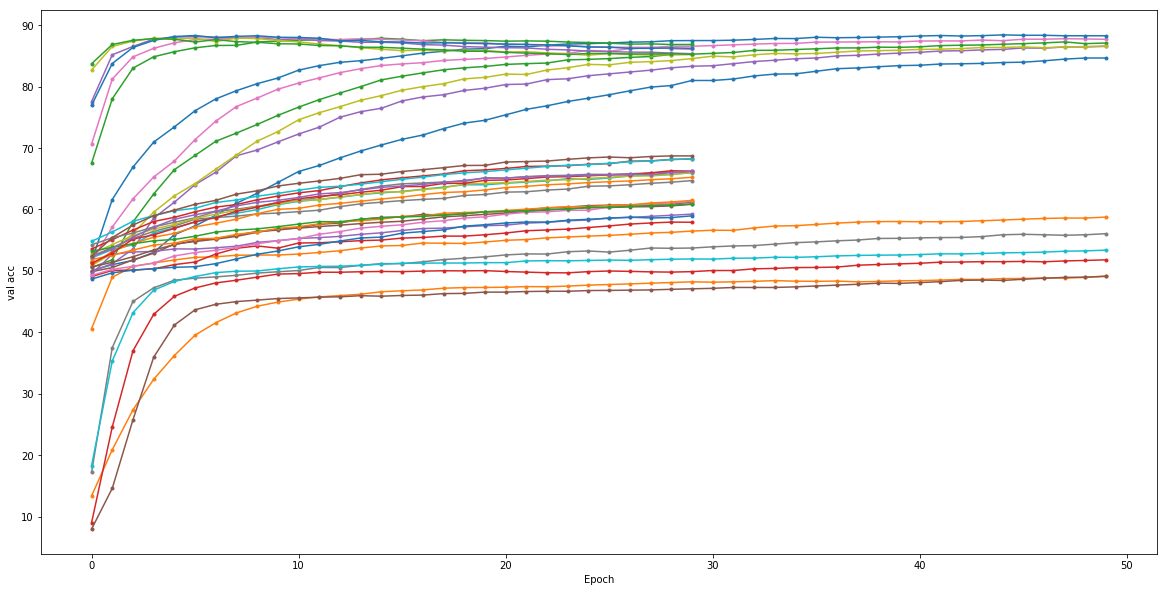

In [21]:
plt.figure(figsize=(20,10))
for i in range(len(Models)):
    plt.plot(Models[i][1],marker = '.', label = 'val acc')
    plt.xlabel("Epoch")
    plt.ylabel("val acc")

# All Combination hyper-parameter Train Loss

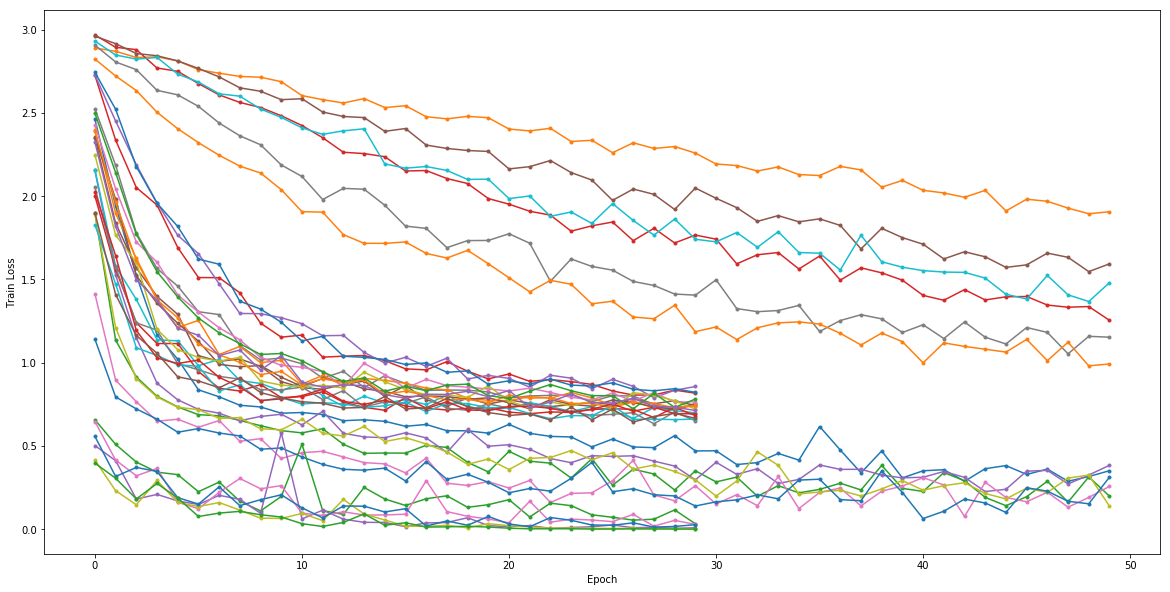

In [22]:
plt.figure(figsize=(20,10))
for i in range(len(Models)):
    plt.plot(Models[i][0],marker = '.', label = 'train loss')
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")

# Best Model Train Loss

Text(0,0.5,'Train Loss')

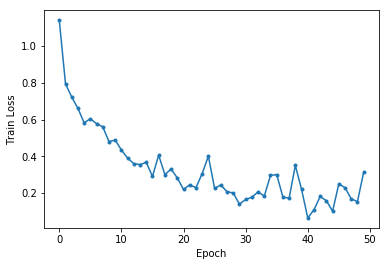

In [23]:
plt.plot(loss_list,marker = '.', label = 'train loss')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

# Best Model Val Acc

Text(0,0.5,'Validation Accuracy')

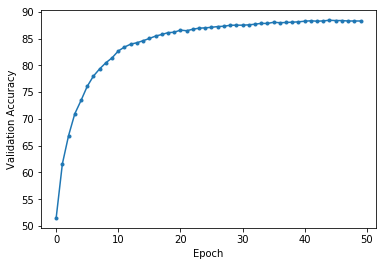

In [24]:
plt.plot(val_list,marker = '.', label = 'Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

# Groupby Plot

In [26]:
### Making Plot
grid = {'emb_dim':[100,200,300],'optimizer':['Adam','SGD'], 'learning_rate': [0.0005,0.001],'adjusted':["yes"]}

df = pd.DataFrame(columns=['adjusted','emb_dim','learning_rate','optimizer'])

for j in ParameterGrid(grid):
    df.loc[len(df)] = list(j.values())

grid = {'emb_dim':[100,200,300],'optimizer':['Adam','SGD'], 'learning_rate': [0.0005,0.001],'adjusted':["no"]}
for j in ParameterGrid(grid):
    df.loc[len(df)] = list(j.values())
    
grid = {'emb_dim':[100,200,300],'optimizer':['Adam'], 'learning_rate': [0.0005,0.001],'adjusted':["linear"]}
for j in ParameterGrid(grid):
    df.loc[len(df)] = list(j.values())
    
grid = {'emb_dim':[100,200,300],'optimizer':['SGD'], 'learning_rate': [0.0005,0.001],'adjusted':["linear"]}
for j in ParameterGrid(grid):
    df.loc[len(df)] = list(j.values())
    
df['best_val_acc'] = [max(model[1]) for model in Models]
df

,adjusted,emb_dim,learning_rate,optimizer,best_val_acc
0,yes,100,0.0005,Adam,84.66
1,yes,100,0.0005,SGD,49.18
2,yes,100,0.0010,Adam,87.28
3,yes,100,0.0010,SGD,51.80
4,yes,200,0.0005,Adam,86.56
5,yes,200,0.0005,SGD,49.10
6,yes,200,0.0010,Adam,87.80
7,yes,200,0.0010,SGD,56.06
8,yes,300,0.0005,Adam,86.62
9,yes,300,0.0005,SGD,53.38


In [40]:
df.groupby('optimizer')[['best_val_acc']].mean().reset_index()

,optimizer,best_val_acc
0,Adam,79.525556
1,SGD,60.210000


In [42]:
df_adam = df[df['optimizer'] == 'Adam']

In [43]:
df_adam.groupby('adjusted')[['best_val_acc']].mean().reset_index()

,adjusted,best_val_acc
0,linear,63.670000
1,no,88.016667
2,yes,86.890000


In [44]:
df_adam.groupby('emb_dim')[['best_val_acc']].mean().reset_index()

,emb_dim,best_val_acc
0,100,78.060000
1,200,79.613333
2,300,80.903333


In [45]:
df_adam.groupby('learning_rate')[['best_val_acc']].mean().reset_index()

,learning_rate,best_val_acc
0,0.0005,78.740000
1,0.0010,80.311111


# 3 correct and 3 incorrect examples

In [217]:
def find_example(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        print(data.shape)
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        print("Labels:",labels)
        print("Prediction:",predicted.flatten())
        print("incorrect prediction: {}".format(np.where(np.array(labels == predicted.flatten()) == 0)[0]))
        if 1:
            break
    return True

In [239]:
example_dataset = ImdbDataset(val_data_indices[0:200], y_val[0:200])
example_loader = torch.utils.data.DataLoader(dataset=example_dataset, 
                                           batch_size=200,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
find_example(example_loader,Models[best_model_idx][2])

torch.Size([200, 200])
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1])
Prediction: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 

True

In [251]:
'''True Predict'''
print(X_val[1]) 
print(0,0)
print(X_val[2]) 
print(1,1)
print(X_val[3])
print(0,0)
print(X_val[77])
print(0,1)
print(X_val[116])
print(1,0)
print(X_val[131])
print(0,1)

Nothing could have saved this movie, not even Superman.<br /><br />Ten years ago the special effects would have been amazing. Better directing might have gotten some more feeling and better performances out of the actors. But nothing but feeding the script to a dragon could have fixed it. Plot holes, bad lines, terrible pacing, endless replaying of the same shots of a CGI dragon stomping through hallways... ugh.<br /><br />Avoid this one at all costs.<br /><br />
0 0
This was a good movie. It wasn't your typical war flick but something a bit different. This movie showed us recruits in training before the war and not actually fighting a war. This film is one of the more realist views on war and the army than most other films like this made. Colin Farrel did a great job at portraying an army recruit and Clifton Collins Jr and also Matthew Davis contributed reasonably well. Seeing Colin Farrel move from b grade to a grade in a few short years, You would never thought it would happen. I wi